In [1]:
from pathlib import Path
import sys

#Simulation definition, more detail in simulation_CPG.py
from simulation_CPG import Simulation_CPG

#Flygym package
from flygym.examples.cpg_controller import CPGNetwork
from flygym.vision import save_video_with_vision_insets
from flygym import Parameters, NeuroMechFly
from flygym.examples.common import PreprogrammedSteps
from hybrid_turning_fly import HybridTurningFly
from flygym import Fly, Simulation, Camera, get_data_path
from flygym.arena import FlatTerrain
from flygym.preprogrammed import all_leg_dofs

#Crop the image from the ommatidia into an hexagonal
from utils import crop_hex_to_rect

# Vision library
import torch
from torch import nn
import torch.nn.functional as F
import cv2
import numpy as np

#Filtering initialization :
import numpy as np
from collections import deque

#Plotting
from tqdm import trange
import pickle
import matplotlib.pyplot as plt
from IPython import display

In [2]:
preprogrammed_steps = PreprogrammedSteps()
swing_periods = preprogrammed_steps.swing_period
legs = preprogrammed_steps.legs

In [17]:
class MovingFly(Fly): #definition of our fly class
    def __init__(self, init_pose="stretch", actuated_joints=None, control="position",
                 initial_position=None, initial_orientation=None, obj_threshold=0.08, decision_interval=0.05, **kwargs):
        super().__init__(**kwargs, init_pose=init_pose, actuated_joints=actuated_joints, control=control,
                         spawn_pos=initial_position, spawn_orientation=initial_orientation, enable_vision=True)
        self.visual_inputs_hist = []
        self.standing=[] #joints angles to stand
        self.strech=[] #linespace to strech the elg
        self.mid_leg_end_effector=[] #init des end effector
        self.fly_pos_hist=[] #history of position
        self.fly_joints_angles_30=[] #history of joints angles
        self.fly_joints_angles_28=[]
        self.fly_joints_angles_9=[]
        self.fly_joints_angles_7=[]
        self.fly_joints_angles_8=[]
        self.fly_joints_angles_31=[]
        self.mid_leg_end_effector_L=[]
        self.mid_leg_end_effector_R=[]

        self.obj_threshold = obj_threshold
        self.decision_interval = decision_interval
        self.num_substeps = int(self.decision_interval / 1e-4)
        self.visual_inputs_hist = []

        self.coms = np.empty((self.retina.num_ommatidia_per_eye, 2))

        for i in range(self.retina.num_ommatidia_per_eye):
            mask = self.retina.ommatidia_id_map == i + 1
            self.coms[i, :] = np.argwhere(mask).mean(axis=0)


            
    def process_visual_observation(self, vision_input): 
        # function to get the distance of the fly based on the size 
        features = np.zeros((2, 3))

        for i, ommatidia_readings in enumerate(vision_input):
            # Identify if readings correspond to an object
            is_obj = ommatidia_readings.max(axis=1) < self.obj_threshold
            is_obj_coords = self.coms[is_obj]

            if is_obj_coords.shape[0] > 0:
                # Compute the mean coordinates for detected objects
                features[i, :2] = is_obj_coords.mean(axis=0)
            
            # Store the number of detected object coordinates (area) in features[i, 2]
            features[i, 2] = is_obj_coords.shape[0]

        # Normalize the y_center and x_center
        features[:, 0] /= self.retina.nrows  # normalize y_center
        features[:, 1] /= self.retina.ncols  # normalize x_center

        # Normalize the area by the number of ommatidia per eye
        features[:, 2] /= self.retina.num_ommatidia_per_eye  # normalize area

        # Flatten the features array and convert to float32
        return features.ravel().astype("float32")

    @staticmethod
    def calc_ipsilateral_speed(deviation, is_found):
        if not is_found:
            return 1.0
        else:
            return np.clip(1 - deviation * 3, 0.4, 1.2)

    def simulate_step(self, sim: Simulation, roll_angle: float, yaw_angle: float, side: str='L'):
        action = {"joints": self.simulate_movement(sim, roll_angle, yaw_angle, side)}
        action["adhesion"] = np.array([1,0,1,1,0,1]) #add adhesion 
        return action

    def simulate_movement(self, sim: Simulation, roll_angle: float, yaw_angle: float, side: str, increment: float = 0.00015,):
        joint_pos = self.standing.copy()

        joint_angles = preprogrammed_steps.get_joint_angles("LM" if side == "L" else "RM", 0)

        if side == "L":
            joint_pos[7:14] = joint_angles + self.strech
            joint_pos[9], joint_pos[7] = roll_angle, yaw_angle  # Setting specific yaw and pitch
        else:
            joint_pos[28:35] = joint_angles + self.strech
            joint_pos[30], joint_pos[28] = roll_angle, yaw_angle

        self.record_mov(sim, side)
        return joint_pos

    def record_mov(self, sim: Simulation, side: str):
        observation = self.get_observation(sim)
        end_effector = observation["end_effectors"]
        if side=='L': self.mid_leg_end_effector.append([end_effector[1,:]])
        else : self.mid_leg_end_effector.append([end_effector[4,:]])
        self.fly_pos_hist.append(observation["fly"]) #record fly position


    def record_joints(self):
        #record joints angles
        joint_pos = self.standing.copy()
        self.fly_joints_angles_30.append(joint_pos[30])
        self.fly_joints_angles_28.append(joint_pos[28])
        self.fly_joints_angles_9.append(joint_pos[9])
        self.fly_joints_angles_7.append(joint_pos[7])
        self.fly_joints_angles_8.append(joint_pos[8])
        self.fly_joints_angles_31.append(joint_pos[31])

    def record_general(self, sim: Simulation):
        observation = self.get_observation(sim)
        end_effector = observation["end_effectors"]
        self.mid_leg_end_effector_L.append([end_effector[1,:]])
        self.mid_leg_end_effector_R.append([end_effector[4,:]])
        #self.fly_pos_hist.append(observation["fly"])
        self.record_joints()
 

In [18]:
def scenario(start_postion=0):
    pos = (0,4.5,0)
    orien_fwd = (0,0,np.pi/2)
    orien_bcd =(0,0,-np.pi/2)

    match start_postion:
        case 0 : return pos, orien_fwd #front right
        case 1: #back right
            pos = (16,4.5,0)
            return pos, orien_bcd
        case 2: #back left
            pos = (16,-4.5,0)
            return pos, orien_bcd
        case 3 :  #front left
            return (0,-5,0), orien_fwd
        case TypeError:
            print("wrong start_position, default values taken")
            return pos, orien_fwd

In [19]:
########################## Choose the desired scenario ###############################
scenario_fly1=0

In [20]:
########################## Camera and fly initialization ###############################

timestep = 1e-4

fly = Fly(
    name="1",
    init_pose="stretch",
    actuated_joints=all_leg_dofs,
    control="position",
    enable_adhesion=True,
    draw_adhesion=False,
    spawn_pos= scenario(scenario_fly1)[0],
    spawn_orientation = scenario(scenario_fly1)[1]
)

fly0 = MovingFly(

    name="0", #static
    init_pose="stretch",
    actuated_joints=all_leg_dofs,
    control="position",
    enable_adhesion=True,
    head_stabilization_model="thorax",
    neck_kp=1000,
    initial_position=(8,0,0), #position
    initial_orientation = (0,0,-np.pi/2)
)


arena = FlatTerrain()

birdeye_cam_zoom = arena.root_element.worldbody.add(
    "camera",
    name="birdeye_cam_zoom",
    mode="fixed",
    pos=(15, 0, 20),
    euler=(0, 0, 0),
    fovy=45,
)

birdeye_cam = arena.root_element.worldbody.add(
    "camera",
    name="birdeye_cam",
    mode="fixed",
    pos=(15, 0, 35),
    euler=(0, 0, 0),
    fovy=45,
)

cam = Camera(
    fly=fly0,
    camera_id="birdeye_cam",
    play_speed=0.5,
    window_size=(600, 400),
)

cam1 = Camera(fly=fly0, play_speed=0.2, draw_contacts=False, camera_follows_fly_orientation=True)

camFront = Camera(fly=fly0, camera_id="Animat/camera_front")
camRight = Camera(fly=fly0, camera_id="Animat/camera_right")
camLeft = Camera(fly=fly0, camera_id="Animat/camera_left")


sim = Simulation(
    flies=[fly0, fly],
    cameras=[cam1, cam, camFront, camRight, camLeft],
    arena=arena,
    timestep=timestep,
)

simulation_cpg = Simulation_CPG(timestep)

In [21]:
########################## Vision Model definition ###############################
#to see the training -> vision.ipynb

class Model(nn.Module):
    def __init__(self):
        super().__init__()
        # Define your layers here
        self.conv1 = nn.Conv2d(2, 8, 3, groups=2)  # Convolutional layer
        self.bn1 = nn.BatchNorm2d(8)
        self.conv2 = nn.Conv2d(8, 8, 3, groups=2)  # Convolutional layer
        self.bn2 = nn.BatchNorm2d(8)
        self.conv3 = nn.Conv2d(8, 8, 3, groups=2)  # Convolutional layer
        self.pool3 = nn.MaxPool2d(2, 2)  # Max pooling layer
        self.fc1 = nn.LazyLinear(16)  # Lazy linear layer
        self.fc2 = nn.Linear(16, 16)  # Linear layer
        self.fc3 = nn.Linear(16, 2)   # Linear layer for output

    def forward(self, x):
        # Define the forward pass
        x = F.tanh(self.conv1(x))
        x = F.relu(self.bn1(x))
        x = F.tanh(self.conv2(x))
        x = self.bn2(x)  # Apply pooling after the second convolution
        x = F.tanh(self.conv3(x))
        x = self.pool3(x)  # Apply pooling after the third convolution
        x = x.flatten(1)   # Flatten the output to feed into linear layers
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = self.fc3(x)
        return x
    

# Create an instance of the model
model = Model()

# Load the model weights
model.load_state_dict(torch.load('./best_model/best_model_vision.pth'))

model.eval()


Model(
  (conv1): Conv2d(2, 8, kernel_size=(3, 3), stride=(1, 1), groups=2)
  (bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), groups=2)
  (bn2): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), groups=2)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): LazyLinear(in_features=0, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=16, bias=True)
  (fc3): Linear(in_features=16, out_features=2, bias=True)
)

In [22]:
########################## Initialization ###############################

run_time=1 #simulation time

#num steps to define the duration of the movement 
target_num_steps=400 #0.3/0.001 enginner joint angles

obs, info = sim.reset(seed=0)

#Put the other fly in black for better detection
for i in fly.model.find_all("geom"):
    sim.physics.named.model.geom_rgba[f"1/{i.name}"] = (0, 0, 0, 1)

area_threshold= 0.003
    

########################## Plot ###############################
second_cam_frames = []
x = None
alpha = 1e-1
yam_history = []
distances_sma_hist = []
theta_pred_sma_hist=[]
real_angle_hist=[]
fly0_pos_record=[]
fly_pos_hist=[]
L_vis_feats=[]
R_vis_feats=[]
Start_record = True
start_id =0
previous_distances_sma=0
distance_cond = False
roll_finished = False
movement_roll=False
finished=False
retract=False
i_roll=0


########################## Filtering ###############################
real_angle=0

n = 50  # Number of observations for moving average
theta_pred_history = deque(maxlen=n)
distances_history = deque(maxlen=n)

area_history = deque(maxlen=400)
area_vis_history=[]


########################## Standing behaviour ###############################
standing_action = []
for leg in legs:
    if leg.endswith("M"):
        standing_action.extend(
            preprogrammed_steps.get_joint_angles(leg, swing_periods[leg][1])
        )
    else:
        standing_action.extend(preprogrammed_steps.get_joint_angles(leg, 0.0))

fly0_action = {"joints": standing_action, "adhesion": np.array([1,0,1,1,0,1])}
fly0.standing= standing_action

Quick notice : 

Here, our roll is the pitch in the documentation

In [23]:
for t in trange(int(run_time / sim.timestep)):
    fly1_action = simulation_cpg.update(fly.actuated_joints)

    obs, _,_ ,_ , info = sim.step({
        "0" : fly0_action,
        "1" : fly1_action,
    })

    obs0, info0 = obs["0"], info["0"]
    fly0.obs = obs0
    render_res = sim.render()[0]

    if render_res is not None:
        fly0.visual_inputs_hist.append(obs0["vision"].copy())
        second_cam = sim.physics.bind(birdeye_cam_zoom)

        x_new = sim._get_center_of_mass()[0]

        if x is None:
            x = x_new

        x = (1 - alpha) * x + alpha * x_new

        second_cam.pos[0] = x
        second_img = sim.physics.render(
            width=700, height=560, camera_id="birdeye_cam_zoom"
        )
        second_img = cv2.putText(
            np.ascontiguousarray(second_img),
            f"{sim.cameras[0].play_speed}x",
            org=(20, 30),
            fontFace=cv2.FONT_HERSHEY_DUPLEX,
            fontScale=0.8,
            color=(0, 0, 0),
            lineType=cv2.LINE_AA,
            thickness=1,
        )
        second_cam_frames.append(second_img)
        

    ########################## NN Vision based inspired from week 4 ###############################
        
    imgs = crop_hex_to_rect(obs0["vision"]) #transform the image into a rectangle by croping
    imgs = np.expand_dims(imgs, axis=0) #transform into a 4d vector to match the training data

    with torch.no_grad(): #gradient doesn't flow back in the model
        coords_lr_pred = model(torch.tensor(imgs)).numpy()

    #prediction of the other fly's position
    theta_pred = np.angle(coords_lr_pred @ (1, -1j) * np.exp(1j * np.pi / 4))
    distances = np.linalg.norm(coords_lr_pred, axis=1)

    #getting the distance from the area covered by the other fly
    visual_features = fly0.process_visual_observation(obs0["vision"])

    L_vis_feats.append(visual_features[2])
    R_vis_feats.append(visual_features[5])
    

    ########################## Filtering ####################################
    #Moving average
    theta_pred_history.append(theta_pred)
    distances_history.append(distances)

    theta_pred_sma = np.mean(theta_pred_history)
    distances_sma = np.mean(distances_history)

    distances_sma_hist.append(distances_sma)
    theta_pred_sma_hist.append(theta_pred_sma)


    ########################## Workspace transcription ###############################

    if theta_pred_sma < 0 :
        side='R'
        real_angle = -(theta_pred_sma + np.deg2rad(90)) #offset on the leg actuator
        area_history.append(visual_features[5])
        area_vis = np.mean(area_history)
    else:
        side='L'
        real_angle= theta_pred_sma - np.deg2rad(90)
        area_history.append(visual_features[2])
        area_vis = np.mean(area_history)

    real_angle_hist.append(real_angle)
    area_vis_history.append(area_vis)


    ########################## Movement computation ###############################
   
    if (area_vis>=area_threshold) and not retract: #if the other fly is in range and not in the retractation movement
        if not distance_cond : start_id = t
        distance_cond = True

        if movement_roll== False: #find roll to give to the fly
            L_midleg_start = preprogrammed_steps.get_joint_angles("LM", 0.0)
            L_midleg_stretch = np.linspace(np.zeros(len(L_midleg_start)), -L_midleg_start, target_num_steps) #iterate backward to have 0 at the end

            R_midleg_start = preprogrammed_steps.get_joint_angles("RM", 0.0)
            R_midleg_stretch = np.linspace( np.zeros(len(R_midleg_start)), -R_midleg_start, target_num_steps)

            if side=='L': #define the linespace of the roll
                roll_lin= np.linspace(obs0["joints"][0][9], 1.57, target_num_steps)
            else : 
                roll_lin= np.linspace(obs0["joints"][0][30], -1.57, target_num_steps)
            movement_roll=True
            previous_angle = real_angle #init
        
        #define the roll and the stretch linespace
        if roll_finished:
            if side=='L':
                roll=1.57 # once finished, stay at 1.5
                fly0.strech=-L_midleg_start
            else: 
                roll=-1.57
                fly0.strech=-R_midleg_start
        else: #the leg isn't fully extended/lifted
            roll = roll_lin[i_roll]   #lift
            if side=='L':
                fly0.strech=L_midleg_stretch[i_roll] #extend the leg
            else: 
                fly0.strech=R_midleg_stretch[i_roll]

        if abs(previous_angle-real_angle)<3: use_angle = real_angle
        else : use_angle = previous_angle
        previous_angle = use_angle

        #yaw linespace
        if i_roll==0: #if iterations is 0 modulo target_num_steps -> compute the new yaw target
            if side=='L':
                joint_value = obs0["joints"][0][7]
                yaw_lin = np.linspace(joint_value, use_angle, target_num_steps)  
            else : 
                joint_value = obs0["joints"][0][28]
                yaw_lin = np.linspace(joint_value, use_angle, target_num_steps)  
                
        yam_history.append(joint_value)

        fly0_action = fly0.simulate_step(sim, roll_angle=roll, yaw_angle=yaw_lin[i_roll], side=side) #action to follow the intruder 

        #update i roll and check if the movement is finished
        i_roll+=1
        if i_roll % target_num_steps == 0 : 
            roll_finished=True
            i_roll=0

        ########################## If no detection ###############################
    elif distance_cond and not finished: #case where the fly walks out of range -> need to retract the leg
        retract=True

        if movement_roll== True: #find roll to give to the fly
            roll_finished=False
            i_roll=0
            L_midleg_start = preprogrammed_steps.get_joint_angles("LM", 0.0)
            L_midleg_stretch = np.linspace(-L_midleg_start,np.zeros(len(L_midleg_start)), target_num_steps) #inverse le mouvement de la jambe qui se deplie

            R_midleg_start = preprogrammed_steps.get_joint_angles("RM", 0.0)
            R_midleg_stretch = np.linspace( -R_midleg_start, np.zeros(len(R_midleg_start)), target_num_steps)

            if side=='L':
                roll_lin= np.linspace(obs0["joints"][0][9], L_midleg_start[2], target_num_steps)
            else : 
                roll_lin= np.linspace(obs0["joints"][0][30], R_midleg_start[2], target_num_steps)
            movement_roll=False


        if roll_finished: #the leg is on the ground/retracted
            finished=True
        else: 
            roll = roll_lin[i_roll]
            if side=='L':
                fly0.strech=L_midleg_stretch[i_roll]
            else: 
                fly0.strech=R_midleg_stretch[i_roll]


        if i_roll==0: #if iterations is 0 modulo target_num_steps -> compute the new yaw target
            if side=='L':
                joint_value = obs0["joints"][0][7]
                yaw_lin = np.linspace(joint_value, fly0.standing[7], target_num_steps)  
            else : 
                joint_value = obs0["joints"][0][28]
                yaw_lin = np.linspace(joint_value, fly0.standing[28], target_num_steps)  
                

        fly0_action = fly0.simulate_step(sim, roll_angle=roll, yaw_angle=yaw_lin[i_roll], side=side) #action to go back to the original position

        #update the counter and check if have reached the target
        i_roll+=1
        if i_roll % target_num_steps == 0 : 
            roll_finished=True
            i_roll=0
            
    else:
        fly0_action = {"joints": standing_action, "adhesion": np.array([1,0,1,1,0,1])} #the fly is in rest position
        

    previous_distances_sma = distances_sma
    observation = fly.get_observation(sim)
    fly_pos_hist.append(observation["fly"])
    fly0.record_general(sim)


    
cam.save_video("./outputs/main_0.mp4", 0)
cam1.save_video("./outputs/main_1.mp4")

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10000/10000 [10:34<00:00, 15.75it/s]


########################## Plotting ###############################

In [24]:
start_id

2701

In [25]:
camFront.save_video("./outputs/front.mp4", 0)
camLeft.save_video("./outputs/left.mp4", 0)
camRight.save_video("./outputs/right.mp4", 0)

display.Video("./outputs/front.mp4")

In [26]:
display.Video("./outputs/left.mp4")

In [27]:
display.Video("./outputs/right.mp4")

In [28]:
cam.save_video("./outputs/jambe_gauchev1.mp4", 0)

display.Video("./outputs/jambe_gauchev1.mp4")

In [29]:
birdeye_cam_frames = cam._frames
cam._frames = second_cam_frames

In [30]:
sim.fly = fly0

save_video_with_vision_insets(
    sim,
    cam,
    "outputs/fly_following_with_retina_images.mp4",
    fly0.visual_inputs_hist,
)

In [31]:
display.Video("./outputs/fly_following_with_retina_images.mp4")

In [32]:
display.Video("./outputs/kinematic_B_replay1.mp4")

In [42]:
frames_per_second = 1 / timestep
time_points_frame = np.arange(0, int(run_time/timestep), 1)
time_points_seconds = np.arange(0, run_time, timestep)

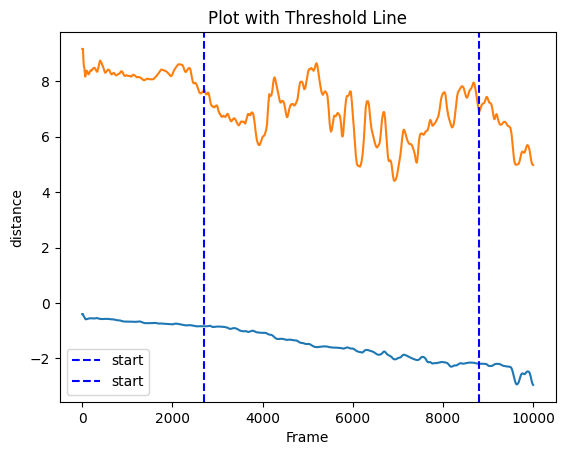

In [33]:
time_points = np.arange(0, int(run_time/timestep), 1)
plt.plot(time_points,theta_pred_sma_hist )
plt.plot(time_points,distances_sma_hist )
# Add a threshold line
# threshold = 8
# plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.axvline(x=start_id, color='b', linestyle='--', label='start')
plt.axvline(x=8800, color='b', linestyle='--', label='start')

# Add labels and legend
plt.xlabel('Frame')
plt.ylabel('distance')
plt.title('Plot with Threshold Line')
plt.legend()

# Show the plot
plt.show()

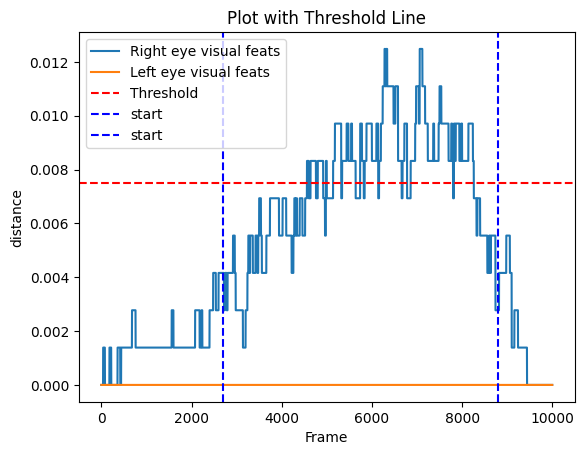

In [34]:
time_points = np.arange(0, int(run_time/timestep), 1)
#plt.plot(time_points,distances_sma_hist )
plt.plot(time_points, R_vis_feats, label='Right eye visual feats')
plt.plot(time_points, L_vis_feats, label='Left eye visual feats')

threshold = 0.0075
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.axvline(x=start_id, color='b', linestyle='--', label='start')
plt.axvline(x=8800, color='b', linestyle='--', label='start')

# Add labels and legend
plt.xlabel('Frame')
plt.ylabel('distance')
plt.title('Plot with Threshold Line')
plt.legend()

# Show the plot
plt.show()

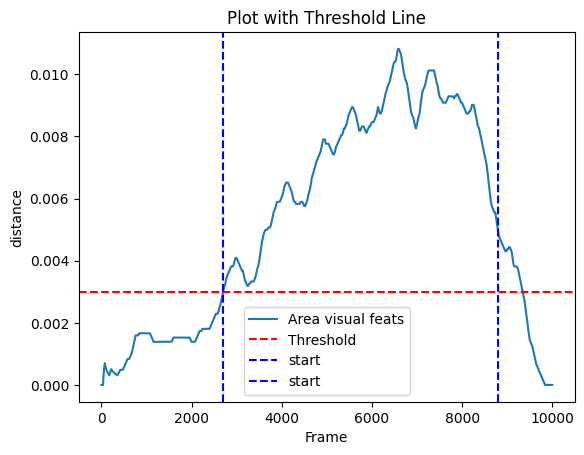

In [35]:
time_points = np.arange(0, int(run_time/timestep), 1)
#plt.plot(time_points,distances_sma_hist )
plt.plot(time_points, area_vis_history, label='Area visual feats')

threshold = 0.003
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.axvline(x=start_id, color='b', linestyle='--', label='start')
plt.axvline(x=8800, color='b', linestyle='--', label='start')

# Add labels and legend
plt.xlabel('Frame')
plt.ylabel('distance')
plt.title('Plot with Threshold Line')
plt.legend()

# Show the plot
plt.show()

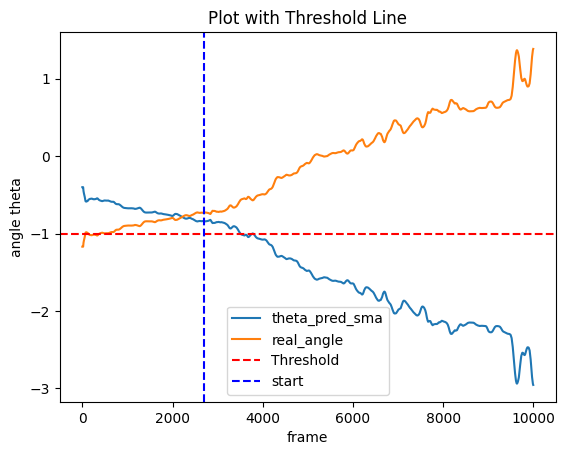

In [55]:
time_points_start = np.arange(start_id, int(run_time/timestep), 1)

plt.plot(time_points, theta_pred_sma_hist, label='theta_pred_sma')
plt.plot(time_points, real_angle_hist, label='real_angle')
# plt.plot(time_points_start, yam_history, label='yam')
# Add a threshold line
threshold = -1
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.axvline(x=start_id, color='b', linestyle='--', label='start')

# Add labels and legend
plt.xlabel('frame')
plt.ylabel('angle theta')
plt.title('Plot with Threshold Line')
plt.legend()

# Show the plot
plt.show()

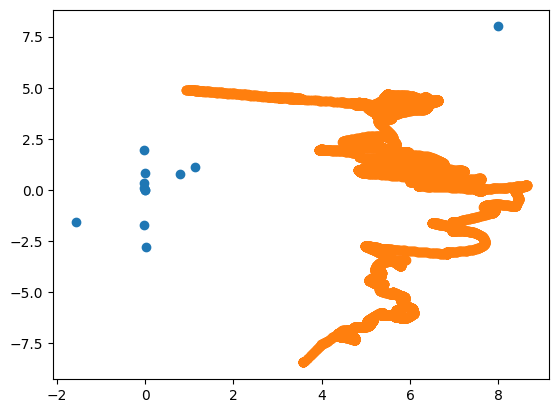

In [37]:
# Function to calculate x and y coordinates given angle and distance
def calculate_trajectory(angle, distance):
    x = distance * np.cos(angle)  # Calculate x coordinate
    y = distance * np.sin(angle)  # Calculate y coordinate
    return x, y

x_traj=[]
y_traj=[]
# Calculate trajectory for each combination of angle and distance
for i in range(len(theta_pred_sma_hist)):
    # Calculate trajectory
    x_traj.append(calculate_trajectory(real_angle_hist[i], distances_sma_hist[i])[0])
    y_traj.append(calculate_trajectory(real_angle_hist[i], distances_sma_hist[i])[1])

    
# Show the plot
plt.scatter (fly0.fly_pos_hist[0], fly0.fly_pos_hist[1])
plt.scatter(x_traj, y_traj)
plt.show()

# plt.savefig('./example/recomputepassLeftPassv2.png')


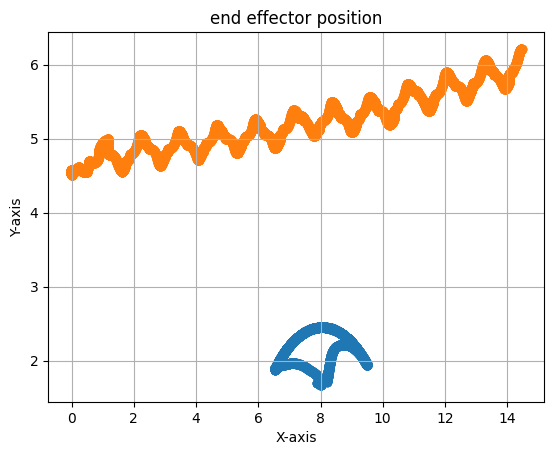

In [38]:
# Extract the first two columns from each array
x_end_eff = [arr[0][0] for arr in fly0.mid_leg_end_effector]
y_end_eff = [arr[0][1] for arr in fly0.mid_leg_end_effector]
z_end_eff = [arr[0][2] for arr in fly0.mid_leg_end_effector]


x_pos = [arr[0][0] for arr in fly_pos_hist]
y_pos = [arr[0][1] for arr in fly_pos_hist]

# Plot the data
plt.scatter(x_end_eff, y_end_eff,  label='end_eff')
plt.scatter(x_pos, y_pos, marker='o', label='pos mov')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('end effector position')
plt.grid(True)
plt.show()
# plt.savefig('./example/fly0vsFlymov_leftPassagev2.png')


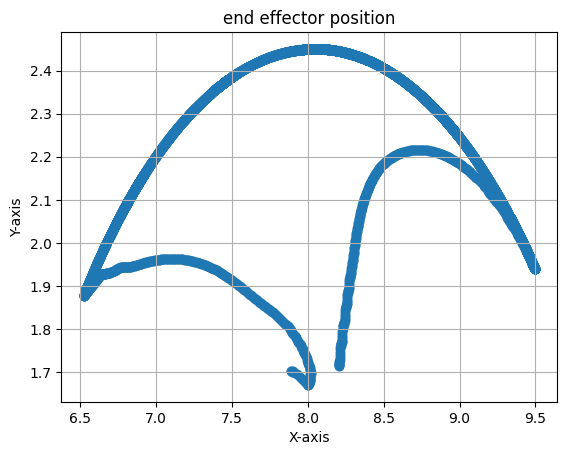

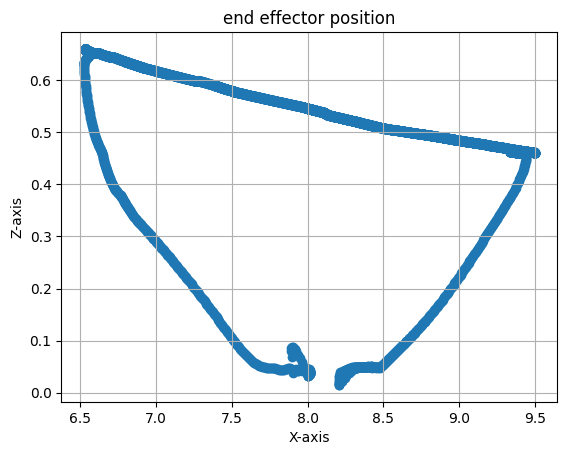

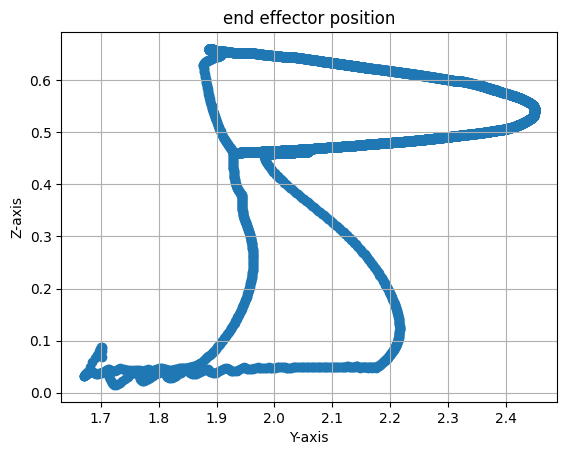

In [39]:
plt.scatter(x_end_eff, y_end_eff, marker='o')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('end effector position')
plt.grid(True)
plt.show()
# plt.savefig('./example/veryVeryNicePassLeftXYv2.png')


plt.scatter(x_end_eff, z_end_eff, marker='o')
plt.xlabel('X-axis')
plt.ylabel('Z-axis')
plt.title('end effector position')
plt.grid(True)
plt.show()
# plt.savefig("./example/veryVeryNicePassLeftXZv2.png")


plt.scatter(y_end_eff, z_end_eff, marker='o')
plt.xlabel('Y-axis')
plt.ylabel('Z-axis')
plt.title('end effector position')
plt.grid(True)
plt.show()
# plt.savefig("./example/veryVeryNicePassLeftYZv2.png")


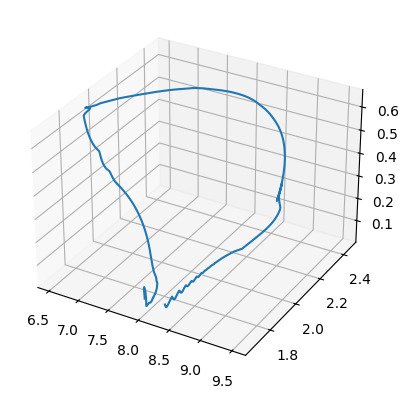

In [52]:
ax = plt.axes(projection='3d')

ax.plot3D(x_end_eff, y_end_eff, z_end_eff)

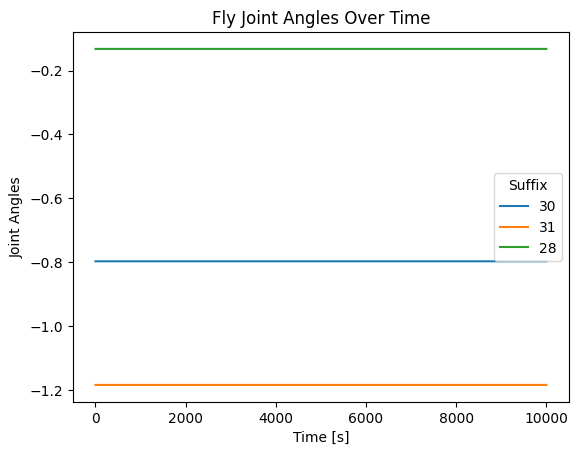

In [58]:
time_points_start = np.arange(start_id, int(run_time/timestep), 1)

suffixes = ['30', '31', '28']

# Loop through each suffix and plot the corresponding data
for suffix in suffixes:
    attribute_name = f'fly_joints_angles_{suffix}'
    data = getattr(fly0, attribute_name)
    plt.plot(time_points, data, label=suffix)

# Add labels, title, and legend
plt.xlabel('Time [s]')
plt.ylabel('Joint Angles')
plt.title('Fly Joint Angles Over Time')
plt.legend(title='Suffix')

# Show the plot
plt.show()

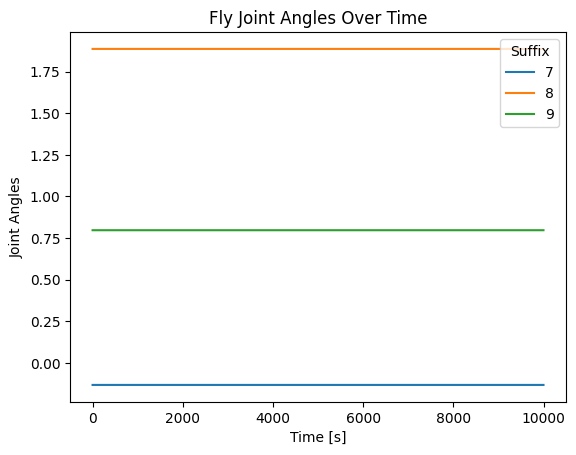

In [59]:
time_points_start = np.arange(start_id, int(run_time/timestep), 1)

suffixes = ['7', '8', '9']

# Loop through each suffix and plot the corresponding data
for suffix in suffixes:
    attribute_name = f'fly_joints_angles_{suffix}'
    data = getattr(fly0, attribute_name)
    plt.plot(time_points, data, label=suffix)

# Add labels, title, and legend
plt.xlabel('Time [s]')
plt.ylabel('Joint Angles')
plt.title('Fly Joint Angles Over Time')
plt.legend(title='Suffix')

# Show the plot
plt.show()